# Anchor-based multi-class classification

* p anchors per class
* k classes
* n features
* m examples

---

## Imports

In [672]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import umap
import imageio

from tqdm import tqdm
from time import time

## Get MNIST Data

In [4]:
import mnist

data_train = mnist.train_images()
data_test = mnist.test_images()

labels_train = mnist.train_labels()
labels_test= mnist.test_labels()

## Prepare data

In [6]:
k = 10 # Number of classes

# X_train.shape = (784, 60000)
# X_test.shape  = (784, 10000)
# Y_train.shape = (10, 60000)
# Y_test.shape  = (10, 10000)

m_train, n, _ = data_train.shape
m_test, _, _ = data_test.shape 

normalize = lambda v: v/255 - 0.5

X_train = normalize(data_train.reshape(m_train, n**2).T)
X_test = normalize(data_test.reshape(m_test, n**2).T)

Y_train = np.eye(k)[labels_train].T
Y_test = np.eye(k)[labels_test].T

## Define functions

In [477]:
def random_mini_batches(X, Y, minibatch_size, seed):
    
    np.random.seed = seed
    
    _, m = X.shape
    
    indices = np.array([i for i in range(m)])
    
    np.random.shuffle(indices)
    
    X = X[:, indices]
    Y = Y[:, indices]
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X[:, i:i+minibatch_size], Y[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def create_placeholders(n, k):
    
    X = tf.placeholder(tf.float32, shape = [n, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [k, None], name = "Y")
    
    return X, Y

def initialize_params(k, p, n, A_init=None, learn_A=True):
    
    # k classes
    # p anchors
    # n features
    
    if type(A_init) != np.ndarray:
        A = tf.get_variable("A", 
                            [k, p, n], 
                            dtype = tf.float32, 
                            initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    else:
        if learn_A:
            A = tf.get_variable("A", 
                                dtype = tf.float32, 
                                initializer = tf.constant(A_init, dtype = tf.float32))
        else:
            A = tf.constant(A_init, name = "A", dtype = tf.float32)
        
    w = tf.get_variable("w", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    b = tf.get_variable("b", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    params = {
        "A": A,
        "w": w,
        "b": b
    }
                        
    return params

def forward_propagate(X, params):

    # A.shape = (k, p, n)
    # X.shape = (n, m)
    # w.shape = (k, 1)
    # b.shape = (k, 1)
    
    A = params["A"]
    w = params["w"]
    b = params["b"]
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    m = tf.shape(X)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_X = tf.reshape(tf.norm(X, axis = 0), (1, m))
    norm = tf.tensordot(norm_A, norm_X, [[2], [0]])
    
    prod = tf.tensordot(A, X, [[2], [0]])
    
    sim = tf.divide(prod, norm) # shape = (k, p, m)
    dist = 1 - sim
    
    D = tf.reshape(tf.reduce_prod(dist, axis = 1), (k, m)) # shape = (k, m)
    H = tf.transpose(tf.nn.softmax(tf.transpose(w * D + b))) # shape = (k, m)
    
    return H

def get_cost(Y, H, epsilon = 0.0001):
    
    # Y.shape = (k, m)
    # H.shape = (k, m)
    
    m = tf.cast(tf.shape(Y)[1], "float32")
    L = - tf.reduce_sum(Y * tf.log(tf.maximum(H, epsilon)), axis = 0)
    cost = 1/m * tf.reduce_sum(L)
    
    return cost

def get_A_reg(A, q=0, epsilon = 0.0001):
    
    # A.shape = (k, p, n)
    
    if q == 0:
        return 0
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_A_T = tf.transpose(norm_A, perm = [0, 2, 1]) # shape = (k, 1, p)
    norm = tf.tensordot(norm_A, norm_A_T, [[1, 2], [2, 1]]) # shape = (k, p, p)
    
    prod = tf.tensordot(A, tf.transpose(A, perm = [0, 2, 1]), [[1, 2], [2, 1]])
    
    sim = tf.divide(prod, norm)
    dist = tf.maximum(1 - sim, epsilon)
    
    energy = 1/2 * tf.reduce_sum(q**2 / dist)
    
    return energy

##### -------------------------------------------------------- #####

def model(X_train, 
          Y_train, 
          X_test, 
          Y_test, 
          A_init=None,
          learn_A=True,
          p=4,
          q=0,
          learning_rate=0.0001,
          num_epochs=1500, 
          minibatch_size=32, 
          print_cost=True,
          plot_cost=False,
          keep_param_history=False,
          img_path=None):
    
    # X_train.shape = (n, m)
    # Y_train.shape = (p, m)
    
    start_tic = time()
    
    print("Beginning training...")
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n, m) = X_train.shape
    k = Y_train.shape[0]
    J_train = []
    J_test = []
    
    X, Y = create_placeholders(n, k)
    params = initialize_params(k, p, n, A_init, learn_A)
    H = forward_propagate(X, params)
    
    if learn_A:
        J = get_cost(Y, H) + get_A_reg(params["A"], q = q)
    else:
        J = get_cost(Y, H)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(J)

    init = tf.global_variables_initializer()
    
    # Initialize list of parameters
    param_history = []
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        tic = time()
        
        param_history.append({"epoch": 0, "params": sess.run(params)})
        J_train.append([0, sess.run(J, feed_dict={X: X_train, Y: Y_train})])
        J_test.append([0, sess.run(J, feed_dict={X: X_test, Y: Y_test})])
        
        for epoch in range(num_epochs):

            epoch += 1
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, J], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 10 == 0:
                dt = time() - tic
                print ("Cost after epoch %i: %f (time elapsed = %f s)" % (epoch, epoch_cost, dt))
                
            if epoch % 1 == 0:
                J_train.append([epoch, epoch_cost])
                J_test.append([epoch, sess.run(J, feed_dict = {X: X_test, Y: Y_test})])
        
            def append_to_params():
                param_history.append({"epoch": epoch, "params": sess.run(params)})
                return
            
            if epoch < 1000:
                append_to_params()
        
        params = sess.run(params)
        probs_train = sess.run(H, feed_dict = {X: X_train})
        probs_test = sess.run(H, feed_dict = {X: X_test})
        
        print("Training complete!")
        
        result = {
            "probs_train": probs_train,
            "probs_test": probs_test,
            "J_train": np.array(J_train).T,
            "J_test": np.array(J_test).T,
            "params": params,
            "training_time": time() - start_tic
        }
        
        if plot_cost:
            plot_J(
                result["J_train"],
                result["J_test"],
                p,
                q,
                learning_rate,
                img_path=img_path
            )
        
        if keep_param_history:
            result["param_history"] = param_history
        
        return result
    
def plot_J(J_train, J_test, p, q, learning_rate, img_path=None, cost_range=None):
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1, 1, 1)
    
    font = {"family": "DejaVu Sans", "weight": "normal", "size" : 14}
    plt.rc("font", **font)
    
    ax.plot(J_train[0], J_train[1], label = "J_train")
    ax.plot(J_test[0], J_test[1], label = "J_test")
    ax.legend()
    ax.set_xlim([0, len(J_train[0])])
    if cost_range is not None:
        ax.set_ylim(cost_range)
    ax.set_ylabel("Cost", fontsize = 16)
    ax.set_xlabel("Epoch", fontsize = 16)
    ax.set_title("%d Anchors: q = %g, α = %g" % (p, q, learning_rate), fontsize=20)
    
    if img_path:
        plt.savefig(img_path, dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.gcf().clear()
    plt.close()
    
    return

## Specify Hyperparameters

In [806]:
k = 10
p = 20
q = 0.1
alpha = 0.1 # 0.001
num_epochs = 100 # 100
initialize_A_with_samples = True
learn_A = True

## Initialize A

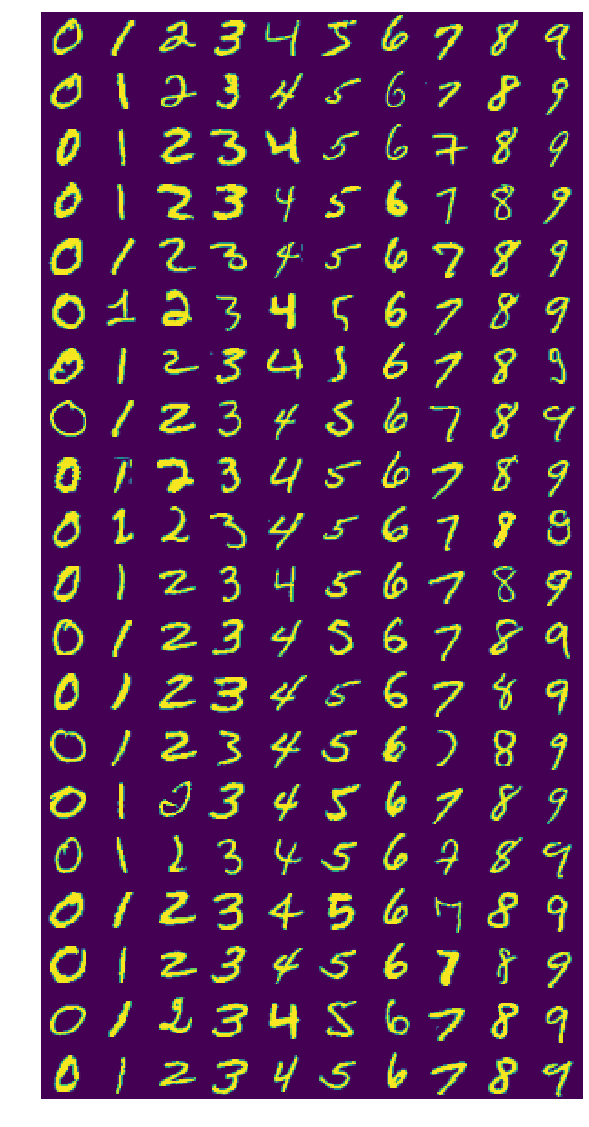

In [807]:
if initialize_A_with_samples:
    
    labels_train.tolist()
    examples = []
    
    for a in range(k):
        matches = np.array([i for i in range(len(labels_train)) if labels_train[i] == a])
        examples.append(matches[:p])
        
    anchor_examples = np.array(examples)

    A_initial = np.array([X_train[:, anchor_examples[i]].T for i in range(10)])
    
    visualize(A_initial - np.min(A_initial))
    
else:
    
    A_initial = None

## Train Model

In [808]:
result = model(
    X_train, 
    Y_train, 
    X_test, 
    Y_test, 
    A_init = A_initial,
    learn_A = learn_A,
    p = p,
    q = q,
    learning_rate = alpha,
    num_epochs = num_epochs, 
    minibatch_size = 32, 
    print_cost = True,
    keep_param_history = True
)

Beginning training...
Cost after epoch 10: 500.652193 (time elapsed = 275.411740 s)
Cost after epoch 20: 500.608622 (time elapsed = 555.337388 s)
Cost after epoch 30: 500.579338 (time elapsed = 831.390427 s)
Cost after epoch 40: 500.552722 (time elapsed = 1108.725237 s)
Cost after epoch 50: 500.529972 (time elapsed = 1385.532120 s)
Cost after epoch 60: 500.515408 (time elapsed = 1659.295506 s)
Cost after epoch 70: 500.498544 (time elapsed = 1905.797582 s)
Cost after epoch 80: 500.486854 (time elapsed = 2121.293839 s)
Cost after epoch 90: 500.480948 (time elapsed = 2335.525225 s)
Cost after epoch 100: 500.469933 (time elapsed = 2549.764887 s)
Training complete!


In [809]:
folder_params = [
    "p=%02d" % p,
    "q=%.0E" % q,
    "alpha=%.0E" % alpha,
    "random_init=%r" % (not initialize_A_with_samples)
]

if not learn_A:
    folder_params.append("learn_A=%r" % learn_A)

model_folder = "images/anchor_training_multiclass/%s" % ", ".join(folder_params)

if not os.path.isdir(model_folder):
    os.mkdir(model_folder)

print(model_folder)

images/anchor_training_multiclass/p=20, q=1E-01, alpha=1E-01, random_init=False


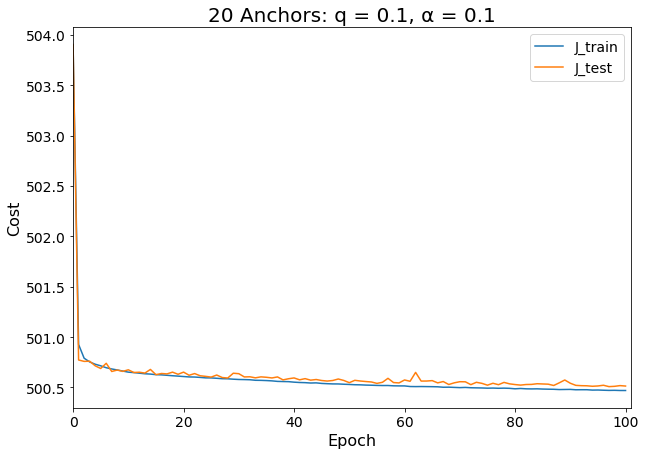

In [810]:
img_path = "%s/cost.png" % model_folder

cost_range = None
# cost_range = [0, 2.3]

plot_J(
    result["J_train"],
    result["J_test"],
    p = p,
    q = q,
    learning_rate = alpha,
    img_path = img_path,
    cost_range = cost_range
)

In [811]:
probs_train = result["probs_train"]
probs_test = result["probs_test"]
params = result["params"]
param_history = result["param_history"]

acc_train = sum(np.argmax(probs_train, axis = 0) == labels_train)/len(labels_train)
acc_test = sum(np.argmax(probs_test, axis = 0) == labels_test)/len(labels_test)

print("Train Accuracy: %f" % acc_train)
print(" Test Accuracy: %f" % acc_test)

summary = {
    "k": k,
    "p": p,
    "q": q,
    "alpha": alpha,
    "num_epochs": num_epochs,
    "initialize_A_with_samples": initialize_A_with_samples,
    "learn_A": learn_A,
    "training_time (s)": result["training_time"],
    "train_accuracy": acc_train,
    "test_accuracy": acc_test
}

summary_path = "%s/training_summary.json" % model_folder

with open(summary_path, "w") as f:
    json.dump(summary, f)

Train Accuracy: 0.972200
 Test Accuracy: 0.957700


Note that increasing the learning rate (alpha) allows the anchors to get pushed **farther** away from their initial positions, thus better exploring the feature space and moving past local minima to more optimal configurations. Time to convergence is actually longer with the higher learning rate (0.1 as opposed to 0.001), but the minimum it reaches is lower (94% vs 92% test accuracy) 

## Visualize Anchors

In [812]:
def v_concat(M, buffer=3):
    
    a, n_h, n_v = M.shape
    buffer_array = np.zeros((buffer, n_h))
    
    result = M[0]
    i = 0
    while i + 1 < a:
        result = np.concatenate([result, buffer_array, M[i + 1]], axis = 0)
        i += 1
    return result


def combine(A, buffer=3):
    
    k, p, n_h, n_v = A.shape
    buffer_array = np.zeros((buffer*(p - 1) + p*n_h, buffer))
    
    result = v_concat(A[0], buffer = buffer)
    
    i = 0
    while i + 1 < k:
        result = np.concatenate([result, buffer_array, v_concat(A[i + 1], buffer = buffer)], axis = 1)
        i += 1
    return result

def visualize(anchors, img_path=None, epoch=None, dpi=None, show=True):
    
    k, p, n = anchors.shape
    A = anchors.reshape(k, p, int(n**0.5), int(n**0.5))
    A = A - np.min(A)
    
    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(combine(A, buffer = 2))
    ax.axis("off")
    
    if epoch is not None:
        ax.text(x = 8,
            y = p * 28 - 5,
            s = "Epoch = %d" % epoch,
            size = 20,
            ha = "left",
            va = "center",
            bbox=dict(facecolor="lightgray",
                      alpha=0.8,
                      boxstyle="round"))
    
    if img_path:
        dpi = 60 if dpi is None else dpi
        plt.savefig(img_path, dpi=dpi, transparent=True, bbox_inches="tight")
    
    if show:
        plt.show()
    
    plt.gcf().clear()
    plt.close()
    
    return

def save_parameter_snapshots(param_history):

    img_folder = "%s/parameter_snapshots" % model_folder

    if not os.path.isdir(img_folder):
        os.mkdir(img_folder)

    for p in tqdm(param_history):
        if p["epoch"] <= 5000:
            try:
                visualize(p["params"]["A"], 
                          img_path = "%s/epoch_%05d" % (img_folder, p["epoch"]),
                          epoch = p["epoch"],
                          show=False)
            except:
                print("Couldn't export image for epoch %d." % p["epoch"])

    print("Exporting complete.")
    
    return

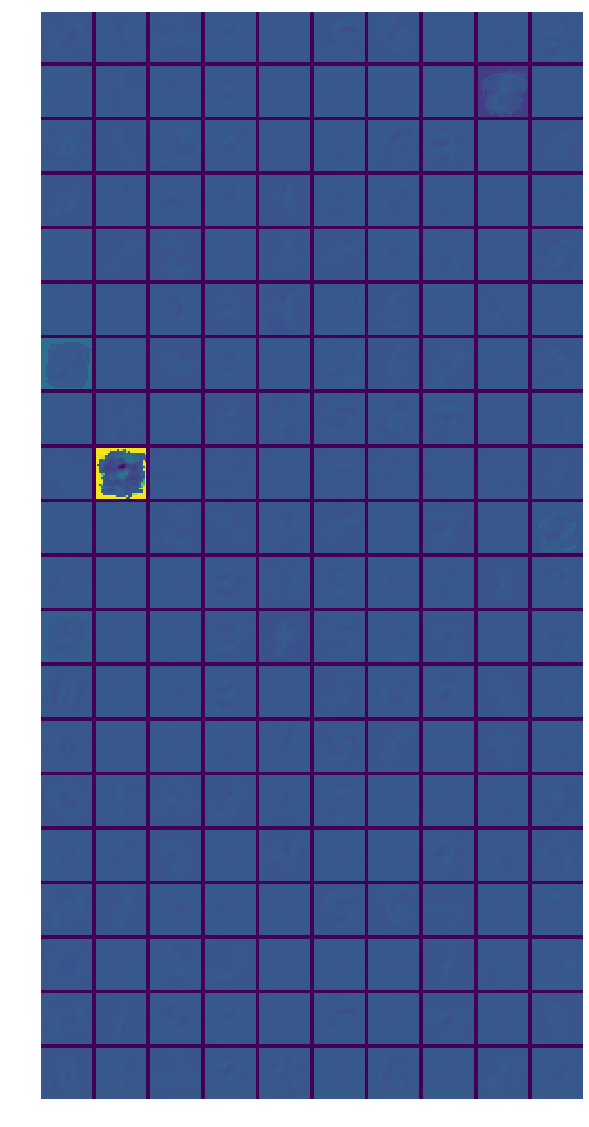

In [813]:
visualize(
    params["A"],
    "%s/learned_anchors.png" % model_folder, 
    dpi=300
)

# Save training history images

In [814]:
if learn_A:
    save_parameter_snapshots(param_history)






  0%|          | 0/101 [00:00<?, ?it/s]




  1%|          | 1/101 [00:00<00:45,  2.19it/s]




  2%|▏         | 2/101 [00:01<00:53,  1.86it/s]




  3%|▎         | 3/101 [00:01<00:58,  1.68it/s]




  4%|▍         | 4/101 [00:02<01:00,  1.59it/s]




  5%|▍         | 5/101 [00:03<00:55,  1.74it/s]




  6%|▌         | 6/101 [00:03<00:54,  1.74it/s]




  7%|▋         | 7/101 [00:04<00:54,  1.71it/s]




  8%|▊         | 8/101 [00:04<00:52,  1.76it/s]




  9%|▉         | 9/101 [00:05<00:59,  1.55it/s]




 10%|▉         | 10/101 [00:06<00:55,  1.65it/s]




 11%|█         | 11/101 [00:06<00:56,  1.58it/s]




 12%|█▏        | 12/101 [00:07<00:57,  1.54it/s]




 13%|█▎        | 13/101 [00:08<00:57,  1.53it/s]




 14%|█▍        | 14/101 [00:08<00:51,  1.68it/s]




 15%|█▍        | 15/101 [00:09<00:48,  1.76it/s]




 16%|█▌        | 16/101 [00:09<00:46,  1.82it/s]




 17%|█▋        | 17/101 [00:10<00:49,  1.70it/s]




 18%|█▊        | 18/101 [00:10<00:48,  1.70it/s]




 19%|█

Exporting complete.


# UMAP

In [815]:
def prepare_umap_data(X_train, 
                      X_test, 
                      labels_train,
                      labels_test):
    """
    Shuffle together training and testing data.
    """

    data = np.concatenate((X_train, X_test), axis = 1).T
    labels = np.concatenate((labels_train, labels_test))

    np.random.seed = 123

    ix = [i for i in range(50000)]
    np.random.shuffle(ix)
    mnist_data = data[ix, :]
    mnist_labels = labels[ix]
    
    return mnist_data, mnist_labels
    
def fit_umap(mnist_data):
    
    tic = time()
    print("Performing UMAP dimensionality reduction...")

    umap_model = umap.UMAP(n_neighbors = 10,
                           min_dist = 0.001, 
                           metric="correlation",
                           random_state=123).fit(mnist_data)

    embedding = umap_model.transform(mnist_data)

    dt = time() - tic

    print("Elapsed time: %.2f seconds" % dt)
    
    return umap_model, embedding

def plot_umap_embedding(embedding,
                        labels,
                        anchor_params=None, 
                        umap_model=None,
                        anchor_alpha=1,
                        epoch=None,
                        img_path=None,
                        dpi=None,
                        show=False):

    fig = plt.figure(figsize = (12, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(embedding[:, 0],
               embedding[:, 1],
               s = 5,
               c = labels,
               cmap = "tab10",
               marker = ".",
               alpha = 0.3,
               edgecolors = "none")
    
    if anchor_params is not None and umap_model is not None:
    
        k, p, n = anchor_params.shape
        anchor_features = np.reshape(anchor_params, [k * p, n])
        anchor_labels = np.array([[i for i in range(k)] for _ in range(p)]).T.reshape(k * p)
        anchor_embedding = umap_model.transform(anchor_features)
    
        ax.scatter(anchor_embedding[:, 0],
                   anchor_embedding[:, 1],
                   s = 500,
                   c = anchor_labels,
                   cmap = "tab10",
                   marker = ".",
                   alpha = 1,
                   edgecolors = "black")
    
    if epoch is not None:
        ax.text(x = -11,
            y = 11.2,
            s = "Epoch = %d" % epoch,
            size = 16,
            ha = "left",
            va = "center",
            bbox=dict(facecolor="lightgray",
                      alpha=0.8,
                      boxstyle="round"))
    
    padding = 1
    minim = np.min(embedding, axis = 0) - padding
    maxim = np.max(embedding, axis = 0) + padding
    
    ax.set_xlim(minim[0], maxim[0])
    ax.set_ylim(minim[1], maxim[1])
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Make Color Bar
    sm = plt.cm.ScalarMappable(cmap="tab10")
    sm.set_array([i - 0.5 for i in range(11)])
    cbar = fig.colorbar(sm, ticks=[i for i in range(10)])
    
    if img_path:
        dpi = 60 if dpi is None else dpi
        plt.savefig(img_path, dpi=dpi, transparent=False, bbox_inches="tight")
    
    if show:
        plt.show()

    plt.gcf().clear()
    plt.close()
    
    return

def save_umap_snapshots(param_history):

    img_folder = "%s/umap_snapshots" % model_folder

    if not os.path.isdir(img_folder):
        os.mkdir(img_folder)

    print("Exporting images...")    

    for p in tqdm(param_history):
        epoch = p["epoch"]
        if epoch <= 5000:
            try:
                plot_umap_embedding(
                    embedding = embedding,
                    labels = mnist_labels,
                    anchor_params = p["params"]["A"],
                    umap_model = umap_model,
                    epoch = epoch,
                    img_path = "%s/epoch_%05d.png" % (img_folder, epoch),
                    show = False
                )
            except:
                print("Couldn't export image for epoch %d." % p["epoch"])

    print("Exporting complete.")
    
    return

## Fit UMAP

In [816]:
# (mnist_data, mnist_labels) = prepare_umap_data(X_train, 
#                                                X_test, 
#                                                labels_train,
#                                                labels_test)

# (umap_model, embedding) = fit_umap(mnist_data)

## Plot with UMAP

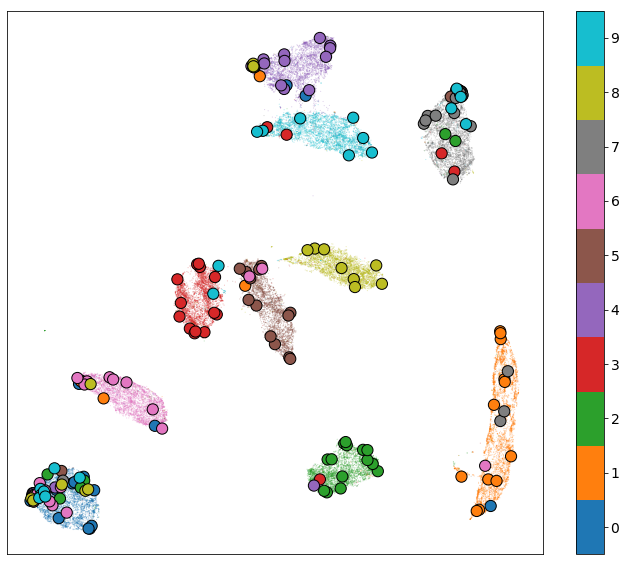

In [817]:
plot_umap_embedding(
    embedding = embedding,
    labels = mnist_labels,
    anchor_params = params["A"],
    umap_model = umap_model,
    img_path = "%s/umap.png" % model_folder,
    dpi = 300,
    show = True
)

In [818]:
if learn_A:
    save_umap_snapshots(param_history)






  0%|          | 0/101 [00:00<?, ?it/s]

Exporting images...







  1%|          | 1/101 [00:03<05:32,  3.33s/it]




  2%|▏         | 2/101 [00:05<04:54,  2.98s/it]




  3%|▎         | 3/101 [00:07<04:16,  2.62s/it]




  4%|▍         | 4/101 [00:09<03:56,  2.44s/it]




  5%|▍         | 5/101 [00:11<03:48,  2.38s/it]




  6%|▌         | 6/101 [00:13<03:37,  2.29s/it]




  7%|▋         | 7/101 [00:15<03:30,  2.24s/it]




  8%|▊         | 8/101 [00:17<03:20,  2.15s/it]




  9%|▉         | 9/101 [00:19<03:11,  2.08s/it]




 10%|▉         | 10/101 [00:21<03:04,  2.02s/it]




 11%|█         | 11/101 [00:23<02:56,  1.96s/it]




 12%|█▏        | 12/101 [00:25<02:51,  1.93s/it]




 13%|█▎        | 13/101 [00:27<02:51,  1.94s/it]




 14%|█▍        | 14/101 [00:29<02:47,  1.92s/it]




 15%|█▍        | 15/101 [00:31<02:50,  1.98s/it]




 16%|█▌        | 16/101 [00:33<02:53,  2.04s/it]




 17%|█▋        | 17/101 [00:35<02:49,  2.02s/it]




 18%|█▊        | 18/101 [00:37<02:44,  1.99s/it]




 19%|█▉        | 19/101 [00:39<02:41,  1.97s/it]



Exporting complete.


## Make GIF

In [819]:
def make_gif(model_folder, 
             name="parameter", 
             duration=0.05, 
             max_length = 51, 
             bookend_length=10):
    
    image_folder = "%s/%s_snapshots" % (model_folder, name)
    gif_path = "%s/%s_snapshots_animation.gif" % (model_folder, name)
    files = [os.path.join(image_folder, x) for x in sorted(os.listdir(image_folder))][:max_length]
    files = [files[0] for x in range(bookend_length)] + files + [files[-1] for x in range(bookend_length)]

    with imageio.get_writer(gif_path, mode='I', duration=duration) as writer:
        for f in tqdm(files):
            image = imageio.imread(f)
            writer.append_data(image)
            
    print("GIF created: '%s'" % gif_path)

In [820]:
for name in ["parameter", "umap"]:
    make_gif(model_folder, name)






  0%|          | 0/71 [00:00<?, ?it/s]




  1%|▏         | 1/71 [00:00<00:17,  3.96it/s]




  4%|▍         | 3/71 [00:00<00:13,  5.04it/s]




  7%|▋         | 5/71 [00:00<00:10,  6.18it/s]




 10%|▉         | 7/71 [00:00<00:08,  7.45it/s]




 13%|█▎        | 9/71 [00:00<00:07,  8.75it/s]




 15%|█▌        | 11/71 [00:00<00:05, 10.12it/s]




 18%|█▊        | 13/71 [00:01<00:05, 10.12it/s]




 21%|██        | 15/71 [00:01<00:05, 10.86it/s]




 24%|██▍       | 17/71 [00:01<00:04, 11.26it/s]




 27%|██▋       | 19/71 [00:01<00:04, 11.00it/s]




 30%|██▉       | 21/71 [00:01<00:04, 10.96it/s]




 32%|███▏      | 23/71 [00:02<00:04, 11.14it/s]




 35%|███▌      | 25/71 [00:02<00:04, 11.03it/s]




 38%|███▊      | 27/71 [00:02<00:03, 11.26it/s]




 41%|████      | 29/71 [00:02<00:03, 11.47it/s]




 44%|████▎     | 31/71 [00:02<00:03, 11.33it/s]




 46%|████▋     | 33/71 [00:02<00:03, 11.42it/s]




 49%|████▉     | 35/71 [00:03<00:03, 11.07it/s]




 52%|█████▏    | 37/7

GIF created: 'images/anchor_training_multiclass/p=20, q=1E-01, alpha=1E-01, random_init=False/parameter_snapshots_animation.gif'







  6%|▌         | 4/71 [00:00<00:04, 14.20it/s]




  8%|▊         | 6/71 [00:00<00:04, 14.67it/s]




 11%|█▏        | 8/71 [00:00<00:04, 14.21it/s]




 14%|█▍        | 10/71 [00:00<00:04, 14.40it/s]




 17%|█▋        | 12/71 [00:00<00:04, 14.44it/s]




 20%|█▉        | 14/71 [00:00<00:03, 14.69it/s]




 23%|██▎       | 16/71 [00:01<00:03, 14.63it/s]




 25%|██▌       | 18/71 [00:01<00:03, 14.53it/s]




 28%|██▊       | 20/71 [00:01<00:03, 14.71it/s]




 31%|███       | 22/71 [00:01<00:03, 14.30it/s]




 34%|███▍      | 24/71 [00:01<00:03, 14.08it/s]




 37%|███▋      | 26/71 [00:01<00:03, 14.13it/s]




 39%|███▉      | 28/71 [00:01<00:02, 14.43it/s]




 42%|████▏     | 30/71 [00:02<00:02, 13.97it/s]




 45%|████▌     | 32/71 [00:02<00:03, 10.73it/s]




 48%|████▊     | 34/71 [00:02<00:03, 11.25it/s]




 51%|█████     | 36/71 [00:02<00:02, 12.12it/s]




 54%|█████▎    | 38/71 [00:02<00:02, 12.71it/s]




 56%|█████▋    | 40/71 [00:02<00:02, 12.97it/s]




 59%|█████

GIF created: 'images/anchor_training_multiclass/p=20, q=1E-01, alpha=1E-01, random_init=False/umap_snapshots_animation.gif'


In [760]:
# def make_gif(image_folder,
#              duration=0.1,
#              bookend_length=10,
#              max_length=51):

#     if os.path.isdir(image_folder):
#         model_folder = "/".join(image_folder.split("/")[:-1])
#         gif_path = "%s/%s_animation.gif" % (model_folder, image_folder.split("/")[-1])
#         files = [os.path.join(image_folder, x) for x in sorted(os.listdir(image_folder))][:max_length]
#         files = [files[0] for x in range(bookend_length)] + files + [files[-1] for x in range(bookend_length)]

#         with imageio.get_writer(gif_path, mode='I', duration=duration) as writer:
#             for f in files:
#                 image = imageio.imread(f)
#                 writer.append_data(image)

# #         print("GIF created: '%s'" % gif_path)
    
#     return

In [762]:
# folder = "images/anchor_training_multiclass"
# dirs = os.listdir(folder)
# model_folders = ["%s/%s" % (folder, x) for x in dirs]

# for m in tqdm(model_folders):
#     for name in ["parameter", "umap"]:
#         image_folder = "%s/%s_snapshots" % (m, name)
#         make_gif(image_folder, 
#                  duration=0.08, 
#                  bookend_length=10,
#                  max_length=51)
        
# print("Done.")